```{index} single: Pyomo; variables
```
```{index} single: Pyomo; expressions
```
```{index} single: Pyomo; sets
```
```{index} single: Pyomo; decorators
```
```{index} single: Pyomo; parameters
```
```{index} single: solver; HiGHS
```

# 1.3 A data-driven Pyomo Model

In this notebook, we'll revisit the production planning example. However, this time we'll demonstrate how Python's data structures, combined with Pyomo's capabilities, can create an optimization model scales with problem data. This enables the model to adjust to new products, varying prices, or changing demand. We refer to this as "data-driven" modeling.

The additional Pyomo components used in this notebook are:

* [Sets](https://pyomo.readthedocs.io/en/6.8.0/pyomo_modeling_components/Sets.html)
* [Parameters](https://pyomo.readthedocs.io/en/6.8.0/pyomo_modeling_components/Parameters.html)

These components enable the use indexed variables and constraints. The combination of sets and indices are essential to building scalable and maintainable models for more complex applications.

We will begin this analysis by examining the problem data sets to identify the underlying problem structure.

## Preamble: Install Pyomo and a solver

The following cell checks if the notebook is run on Google Colab. If so, it does a quiet installation of Pyomo and the HiGHS solver. The solver is then selected, a test performed to verify that the solver is available, and the solver interface is stored in a global object `SOLVER` for later use.

In [16]:
import sys

if 'google.colab' in sys.modules:
    %pip install pyomo >/dev/null 2>/dev/null
    %pip install highspy >/dev/null 2>/dev/null

solver = 'appsi_highs'

import pyomo.environ as pyo
SOLVER = pyo.SolverFactory(solver)

assert SOLVER.available(), f"Solver {solver} is not available."

### *Step 1. Import Pyomo*

In [2]:
import pyomo.environ as pyo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx

### *Step 2. The ConcreteModel Object*

In [5]:
model = pyo.ConcreteModel("Production Planning: Version 1")
model.display()
type(model)

Model 'Production Planning: Version 1'

  Variables:
    None

  Objectives:
    None

  Constraints:
    None


pyomo.core.base.PyomoModel.ConcreteModel

### *Step 3. Decision Variabvles*

In [6]:
model.x_M = pyo.Var(bounds=(0, None))
model.x_A = pyo.Var(bounds=(0, 80))
model.x_B = pyo.Var(bounds=(0, 100))
model.y_U = pyo.Var(bounds=(0, 40))
model.y_V = pyo.Var(bounds=(0, None))

### *Step 4. Expressions*
### *Step 5. Objective*

In [12]:
model.cost = 10 * model.x_M + 50 * model.x_A + 40 * model.x_B
model.revenue = 270 * model.y_U + 210 * model.y_V
# define the objective function using the Objective class
model.profit = pyo.Objective(expr = model.revenue - model.cost, sense = pyo.maximize)

# define the objective function using decotators
@model.Objective(sense = pyo.maximize)
def profit(m):
  return m.revenue - m.cost

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


### *Step 6. Constraints*

In [14]:
model.raw_materials = pyo.Constraint(expr = 10 * model.y_U + 9 * model.y_V <= model.x_M)
model.labor_A = pyo.Constraint(expr = 1 * model.y_U + 1 * model.y_V <= model.x_A)
model.labor_B = pyo.Constraint(expr = 2 * model.y_U + 1 * model.y_V <= model.x_B)

# decorators
# @model.Constraint()
# def raw_materials(m):
#   return 10 * m.y_U + 9 * m.y_V <= m.x_M

# @model.Constraint()
# def labor_A(m):
#   return 1 * m.y_U + 1 * m.y_V <= m.x_A

# @model.Constraint()
# def labor_B(m):
#   return 2 * m.y_U + 1 * m.y_V <= m.x_B


This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


Running HiGHS 1.10.0 (git hash: fd86653): Copyright (c) 2025 HiGHS under MIT licence terms
RUN!
LP   has 3 rows; 5 cols; 9 nonzeros
Coefficient ranges:
  Matrix [1e+00, 1e+01]
  Cost   [1e+01, 3e+02]
  Bound  [4e+01, 1e+02]
  RHS    [0e+00, 0e+00]
Presolving model
2 rows, 4 cols, 6 nonzeros  0s
Dependent equations search running on 2 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
2 rows, 4 cols, 6 nonzeros  0s
Presolve : Reductions: rows 2(-1); columns 4(-1); elements 6(-3)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -2.0999953995e+02 Ph1: 2(4); Du: 3(210) 0s
          3    -2.6000000000e+03 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model status        : Optimal
Simplex   iterations: 3
Objective value     :  2.6000000000e+03
Relative P-D gap    :  0.0000000000e+00
HiGHS run time      :       

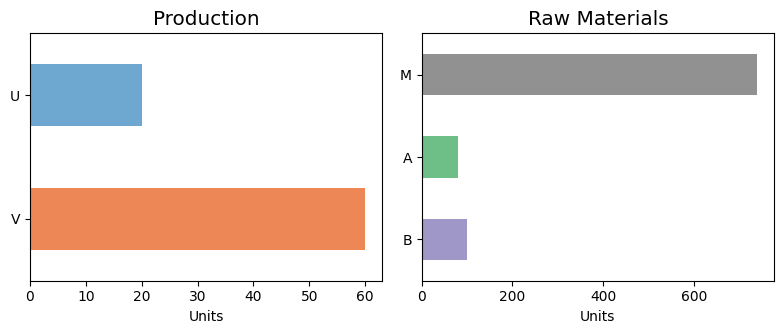

In [17]:
results = SOLVER.solve(model, tee=True)

# display the whole model
model.pprint()
# display the components of the model
model.profit.pprint()

# print the value  of variables
print(f" Profit = {pyo.value(model.profit):9.2f}")
print(f"Revenue = {pyo.value(model.revenue):9.2f}")
print(f"Cost    = {pyo.value(model.cost):9.2f}")
print(f"x_M     = {pyo.value(model.x_M):9.2f}")
print(f"x_A     = {pyo.value(model.x_A):9.2f}")
print(f"x_B     = {pyo.value(model.x_B):9.2f}")

## Pandas

production = pd.Series(
    {
        "U": pyo.value(model.y_U),
        "V": pyo.value(model.y_V),
    }
)

raw_materials = pd.Series(
    {
        "M": pyo.value(model.x_M),
        "A": pyo.value(model.x_A),
        "B": pyo.value(model.x_B),
    }
)

# creat 1 x 2 grid of subplots and configure global settings
fig, ax =plt.subplots(1, 2, figsize=(8, 3.5))
plt.rcParams["font.size"] = 12
colors = plt.cm.tab20c.colors
color_sets = [[colors[0], colors[4]],[colors[16], colors[8], colors[12]]]
datasets = [production, raw_materials]
titles = ["Production", "Raw Materials"]

# plot data on subplots
for i, (data, title, color_set) in enumerate(zip(datasets, titles, color_sets)):
  data.plot(ax=ax[i], kind="barh", title=title, alpha=0.7, color=color_set)
  ax[i].set_xlabel("Units")
  ax[i].invert_yaxis()
plt.tight_layout()
plt.show()

## Data representations

We begin by revisiting the data sets and mathematical model developed for the basic production planning problem presented in the [previous notebook](02-production-planning-basic.ipynb). The original data sets were given as:

<div align="center">

| Product | Material <br> required | Labor A <br> required | Labor B <br> required | Market <br> Demand | Price |
| :-: | :-: | :-: | :-: | :-: | :-: |
| U | 10 g | 1 hr | 2 hr | $\leq$ 40 units | 270$ |
| V |  9 g | 1 hr | 1 hr | unlimited | 210$ |

</div>
and
<div align="center">

| Resource | Amount <br> Available | Cost |
| :-: | :-: | :-: |
| Material | unlimited | 10$ / g |
| Labor A | 80 hours | 50$ / hour |
| Labor B | 100 hours | 40$ / hour |

</div>

Two distinct sets of objects are evident from these tables. The first is the set of products comprised of $U$ and $V$. The second is the set of resources used to produce those products, which we abbreviate as $M$, $A$, and $B$.

Having identified these sets, the data for this application be factored into three simple tables. The first two tables list attributes of the products and resources, the third table summarizes the process used to create the products from the resources:

**Table: Products**

<div align="center">

| Product | Demand | Price |
| :-: | :-: | :-: |
| U |  $\leq$ 40 units | 270$ |
| V |  unlimited | 210$ |

</div>

**Table: Resources**

<div align="center">

| Resource | Available | Cost |
| :-: | :-: | :-: |
| Material | unlimited | 10$ / g |
| Labor A | 80 hours | 50$ / hour |
| Labor B | 100 hours | 40$ / hour |

</div>

**Table: Processes**

<div align="center">

| Product | Material | Labor A | Labor B
| :-: | :-: | :-: | :-: |
| U | 10 g | 1 hr | 2 hr |
| V |  9 g | 1 hr | 1 hr |

</div>

Python has many built-in data types and libraries that are useful for handling tabular data, and there are several options that would be appropriate for the task at hand. Nested dictionaries can be a good choice for smaller problems that have only a few columns. In the following examples, we will show how nested dictionaries can be used to represent the three tables that were described above.

The first table of these describes the products. The product names will serve as keys for outermost dictionary, and attribute names as keys for the inner dictionaries. The attribute values will be interpreted as floating point numbers. `None` is used when a value is not present.

In [ ]:
products = {
    "U": {"price": 270, "demand": 40},
    "V": {"price": 210, "demand": None},
}

# print data
for product, attributes in products.items():
    for attribute, value in attributes.items():
        print(f"{product} {attribute:10s} {value}")

U price      270
U demand     40
V price      210
V demand     None


The second table is the nested dictionary listing attributes and values for resources consumed.

In [ ]:
resources = {
    "M": {"price": 10, "available": None},
    "labor A": {"price": 50, "available": 80},
    "labor B": {"price": 40, "available": 100},
}

for resource, attributes in resources.items():
    for attribute, value in attributes.items():
        print(f"{resource:8s} {attribute:10s} {value}")

M        price      10
M        available  None
labor A  price      50
labor A  available  80
labor B  price      40
labor B  available  100


The third table data shows the amount of each resource needed to produce one unit of each product. The rows are labeled by product, and the columns labeled by by resource.

In [ ]:
processes = {
    "U": {"M": 10, "labor A": 1, "labor B": 2},
    "V": {"M": 9, "labor A": 1, "labor B": 1},
}

for product, process in processes.items():
    for resource, value in process.items():
        print(f"{product:4s} {resource:10s} {value}")

U    M          10
U    labor A    1
U    labor B    2
V    M          9
V    labor A    1
V    labor B    1


## Mathematical model

By rearranging the problem data into straightforward tables, the structure of the production planning problem becomes evident. We can identify a set of products, a set of resources, and a collection of parameters that specify the processes for transforming resources into products. Compared to the previous notebook, these abstractions allow us to create mathematical models that can adapt and scale with the supplied data.

Let $\cal{P}$ and $\cal{R}$ be the set of products and resources, respectively, and let $p$ and $r$ be representative elements of those sets. We use indexed decision variables $x_r$ and $y_p$ to denote the amount of resource $r$ that is consumed in production, and $y_p$ to denote the amount of product $p$ produced.

The problem data provides attributes that constrain the decision variables. For example, the decision variables all have lower bounds of zero, and some have upper bounds. We represent these as

$$
\begin{aligned}
    0 \leq x_r \leq b_r & & \forall r\in\cal{R} \\
    0 \leq y_p \leq b_p & & \forall p\in\cal{P} \\
\end{aligned}
$$

where the upper bounds, $b_r$ and $b_p$, come from the tables of attributes. For cases where the upper bounds don't apply, we can either insert bounds larger than would ever be encountered, or, when we translate this model to Pyomo, designate a special value that causes the bound to be ignored.

The objective is given as before,

$$
\begin{aligned}
    \text{profit} & = \text{revenue} - \text{cost} \\
\end{aligned}
$$

but now the expressions for revenue and cost are

$$
\begin{aligned}
    \text{revenue} & = \sum_{p\in\cal{P}} c_p y_p  \\
    \text{cost} & = \sum_{r\in\cal{R}} c_r x_r \\
\end{aligned}
$$

where $c_r$ and $c_p$ are parameters specifying the price for resources and products. The bounds on available resources can be written as

$$
\begin{aligned}
    \sum_{p\in\cal{P}} a_{r, p} y_p & \leq x_r & \forall r\in\cal{R}
\end{aligned}
$$

Putting these pieces together, we have the following model for the production planning problem.

$$
\begin{align}
\max \quad & \text{profit} = \sum_{p\in\cal{P}} c_p y_p - \sum_{r\in\cal{R}} c_r x_r \\
\text{such that} \quad & \sum_{p\in\cal{P}} a_{r, p} y_p  \leq x_r & \forall r\in\cal{R} \nonumber \\
 &   0 \leq x_r \leq b_r & \forall r\in\cal{R} \nonumber  \\
 &   0 \leq y_p \leq b_p & \forall p\in\cal{P} \nonumber  \\
\end{align}
$$

Compared to the previous notebook, when formulated this way, the model can be applied to any problem with the same structure, regardless of the number of products or resources. This flexibility is possible due to the use of sets to describe the products and resources for a particular problem, indices to refer to elements of those sets, and data tables that hold the relevant parameter values.

Generalizing mathematical models in this fashion is a common feature of many data science applications. Next we will see how this type of generalization is facilitated in Pyomo.

## The production model in Pyomo

As before, we begin the construction of a Pyomo model by creating a `ConcreteModel`.

In [ ]:
model = pyo.ConcreteModel()

In mathematical optimization and modeling, a set serves as an indexed collection of elements that allows you to define variables, constraints, and other model components in a generalized way. Pyomo's `Set()` component serves the same purpose: it is used for defining index sets over which variables, parameters, constraints, or objectives can be defined.

We use the Pyomo `Set()` to construct sets corresponding to the products and resources. Each set is initialized with the dictionary keys for the relevant attribute tables. These will later become indices for parameters, decision variables, and constraints.

In [ ]:
model.PRODUCTS = pyo.Set(initialize=products.keys())
model.RESOURCES = pyo.Set(initialize=resources.keys())

The next step is to introduce parameters that will be used in the constraints and objective functions. These are indexed by products, or resources, or both. The parameter values are assigned to model name. We use Pyomo decorators to declare these parameters, where the function between decorated becomes the name of the parameter, and the function returns the parameter value from the problem data sets. This forms the interface between problem data and the Pyomo model.

This step of declaring Pyomo `Param` objects is often omitted in Pyomo applications. In doing so, the modeler is making a choice to embed the external data representation directly into objectives and constraints of the problem. This can be effective, it does keep the code shorter, and may remove some computational overhead. However, it also blurs the boundary between the data representation and the model statements. Any change in data representation may require editing every place where that data is used in the model. By defining model parameters with `Param()`, the interface to the data representation is located in one clearly defined portion of a larger model, thereby significantly improving the long-term maintainabiity of models. This concern may be overkill in small models like we have here, but is a key consideration when constructing more complex applications.

Note: The domain for the bounds is set to `Any` because some of them will take value `None`. Pyomo will omit a lower or upper bounds that has a value of `None`, so this is a way to keep the logic simple.

In [ ]:
# parameter for bounds
@model.Param(model.PRODUCTS, domain=pyo.Any)
def demand(model, product):
    return products[product]["demand"]


@model.Param(model.RESOURCES, domain=pyo.Any)
def available(model, resource):
    return resources[resource]["available"]


# parameter with price coefficients
@model.Param(model.PRODUCTS)
def cp(model, product):
    return products[product]["price"]


@model.Param(model.RESOURCES)
def cr(model, resource):
    return resources[resource]["price"]


# process parameters: a[r,p]
@model.Param(model.RESOURCES, model.PRODUCTS)
def a(model, resource, product):
    return processes[product][resource]

The decision variables, $x$ and $y$, are indexed by the set of resources and products, respectively. The indexing is specified by passing the relevant sets as the first argumentns to Pyomo `Var()`. In addition to indexing, it always good practice to specify any known and fixed bounds on the variables. This is done by specifying a function (in Pyomo parlance sometimes called a rule) that returns the bound for a given index. Here we use a Python lambda function with two arguments, model and an index referring to a member of a set, to return a tuple with the lower and upper bound.

In [ ]:
model.x = pyo.Var(
    model.RESOURCES, bounds=lambda model, resource: (0, model.available[resource])
)
model.y = pyo.Var(
    model.PRODUCTS, bounds=lambda model, product: (0, model.demand[product])
)

The objective is expressed with Pyomo `quicksum` which accepts a Python generator to successive terms in the sum. Here we use the parameters $c_p$ and $c_r$ that appear in the mathematical version of the model, and which were declared above in the Pyomo version of the model.

In [ ]:
model.revenue = pyo.quicksum(
    model.cp[product] * model.y[product] for product in model.PRODUCTS
)
model.cost = pyo.quicksum(
    model.cr[resource] * model.x[resource] for resource in model.RESOURCES
)


# create objective
@model.Objective(sense=pyo.maximize)
def profit(model):
    return model.revenue - model.cost

The Pyomo `Constraint` decorator accepts one or more sets as arguments. Then, for every member of every set, the decorated function creates an associated constraint. Creating indexed constraints indexed in this manner are an essential building block for more complex models.

In [ ]:
# create indexed constraint
@model.Constraint(model.RESOURCES)
def materials_used(model, resource):
    return (
        pyo.quicksum(
            model.a[resource, product] * model.y[product] for product in model.PRODUCTS
        )
        <= model.x[resource]
    )

The final step is to solve the model and report the solution. Here we create a simple report using `pyo.value()` to access values of the decision variables, and using the model sets to construct iterators to report the value of indexed variables.

In [ ]:
model.pprint()

# solve
SOLVER.solve(model)

# create a solution report
print(f"Profit = {pyo.value(model.profit)}")

print("\nProduction Report")
for product in model.PRODUCTS:
    print(f" {product}  produced =  {pyo.value(model.y[product])}")

print("\nResource Report")
for resource in model.RESOURCES:
    print(f" {resource} consumed = {pyo.value(model.x[resource])}")

3 Set Declarations
    PRODUCTS : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {'U', 'V'}
    RESOURCES : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'M', 'labor A', 'labor B'}
    a_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain             : Size : Members
        None :     2 : RESOURCES*PRODUCTS :    6 : {('M', 'U'), ('M', 'V'), ('labor A', 'U'), ('labor A', 'V'), ('labor B', 'U'), ('labor B', 'V')}

5 Param Declarations
    a : Size=6, Index=a_index, Domain=Any, Default=None, Mutable=False
        Key              : Value
              ('M', 'U') :    10
              ('M', 'V') :     9
        ('labor A', 'U') :     1
        ('labor A', 'V') :     1
        ('labor B', 'U') :     2
        ('labor B', 'V') :     1
    available : Size=3, Index=RESOURCES, Domain=Any, Default=None, Mutable=False
    

## For Python experts: Creating subclasses of `ConcreteModel`

Some readers of these notebooks may be more experienced Python developers who wish to apply Pyomo in more specialized, data driven applications. The following cell shows how the Pyomo `ConcreteModel()` class can be extended by subclassing to create specialized model classes. Here we create a subclass called `ProductionModel` that accepts a particular representation of the problem data to produce a production model object. The production model object inherits all of the methods associated with any `ConcreteModel`, such as `.display()`, `.solve()`, and `.pprint()`, but can be extended with additional methods.

In [ ]:
class ProductionModel(pyo.ConcreteModel):
    """
    A class representing a production model using Pyomo.
    """

    def __init__(self, products, resources, processes):
        """
        Initialize ProductionModel as an instance of a ConcreteModel.

        :param products: A dictionary containing product information.
        :param resources: A dictionary containing resource information.
        :param processes: A dictionary containing process information.
        """
        super().__init__("Production Model")

        # save data in the model instance
        self.products = products
        self.resources = resources
        self.processes = processes

        # flag to monitor solution status
        self.solved = False

    def build_model(self):
        """
        Build the optimization model.
        """
        # access the model
        model = self.model()

        # create sets to index variables and constraints
        model.PRODUCTS = self.products.keys()
        model.RESOURCES = self.resources.keys()

        # decision variables
        model.x = pyo.Var(
            model.RESOURCES,
            bounds=lambda model, resource: (0, self.resources[resource]["available"]),
        )
        model.y = pyo.Var(
            model.PRODUCTS,
            bounds=lambda model, product: (0, self.products[product]["demand"]),
        )

        # use expressions to break up complex objectives
        model.revenue = pyo.quicksum(
            self.products[product]["price"] * model.y[product]
            for product in model.products
        )
        model.cost = pyo.quicksum(
            self.resources[resource]["price"] * model.x[resource]
            for resource in model.resources
        )

        # create objective
        @model.Objective(sense=pyo.maximize)
        def profit(model):
            return model.revenue - model.cost

        # create indexed constraint
        @model.Constraint(model.RESOURCES)
        def materials_used(model, resource):
            return (
                pyo.quicksum(
                    self.processes[product][resource] * model.y[product]
                    for product in model.PRODUCTS
                )
                <= model.x[resource]
            )

    def solve(self, solver=SOLVER):
        """
        Buildthe model, if necessary, then solve the optimization model.
        """
        self.build_model()
        solver.solve(self)
        self.solved = True

    def report(self):
        """
        Solve, if necessary, then report the model solution.
        """
        if not self.solved:
            self.solve(SOLVER)
        print(f"Profit = {pyo.value(self.profit)}")
        print("\nProduction Report")
        for product in m.PRODUCTS:
            print(f" {product}  produced =  {pyo.value(self.y[product])}")
        print("\nResource Report")
        for resource in m.RESOURCES:
            print(f" {resource} consumed = {pyo.value(self.x[resource])}")


m = ProductionModel(products, resources, processes)
m.report()

Profit = 2600.0

Production Report
 U  produced =  20.0
 V  produced =  60.0

Resource Report
 M consumed = 740.0
 labor A consumed = 80.0
 labor B consumed = 100.0
